In [54]:
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Concatenate
from tqdm import tqdm

In [55]:
# Load the finalized dataset
df = pd.read_csv("../Datasets/pokedex_final.csv")

# Combine type1 and type2 into a list
df['type_list'] = df[['type1', 'type2']].values.tolist()
df['type_list'] = df['type_list'].apply(lambda x: [t for t in x if pd.notna(t) and t != ''])

# Encode the types with MultiLabelBinarizer
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['type_list'])

# Tokenize the enhanced_info column
text_tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
text_tokenizer.fit_on_texts(df['enhanced_info'])

sequences = text_tokenizer.texts_to_sequences(df['enhanced_info'])
X_text = pad_sequences(sequences, maxlen=300, padding='post', truncating='post')

# Normalize numeric features
stats_cols = ['hp', 'attack', 'defense', 's_attack', 'speed', 'height', 'weight']
scaler = StandardScaler()
X_stats = scaler.fit_transform(df[stats_cols])

In [56]:
# Split into train and test sets
X_train_text, X_test_text, X_train_stats, X_test_stats, y_train, y_test = train_test_split(
    X_text, X_stats, y, test_size=0.2, random_state=42)

# Build the RNN + Stats model
input_text = Input(shape=(300,), name='text_input')
text_embed = Embedding(input_dim=5000, output_dim=64, input_length=300)(input_text)
# text_lstm = LSTM(64)(text_embed)
text_lstm = LSTM(128, dropout=0.2)(text_embed)

input_stats = Input(shape=(X_stats.shape[1],), name='stats_input')

combined = Concatenate()([text_lstm, input_stats])
# hidden = Dense(128, activation='relu')(combined)
hidden = Dense(256, activation='relu')(combined)
output = Dense(len(mlb.classes_), activation='sigmoid')(hidden)

model = Model(inputs=[input_text, input_stats], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

# Train the model
model.fit(
    [X_train_text, X_train_stats],
    y_train,
    validation_data=([X_test_text, X_test_stats], y_test),
    epochs=50,
    batch_size=32
)

# Save model and label binarizer
model.save("rnn_stats_pokemon_model")  # Saves to your project folder
pd.DataFrame(mlb.classes_, columns=['Type']).to_csv("type_classes.csv", index=False)

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 300)]                0         []                            
                                                                                                  
 embedding_9 (Embedding)     (None, 300, 64)              320000    ['text_input[0][0]']          
                                                                                                  
 lstm_9 (LSTM)               (None, 128)                  98816     ['embedding_9[0][0]']         
                                                                                                  
 stats_input (InputLayer)    [(None, 7)]                  0         []                            
                                                                                            

INFO:tensorflow:Assets written to: rnn_stats_pokemon_model/assets


In [57]:
from tensorflow.keras.models import load_model

# Load your saved RNN model
model = load_model("rnn_stats_pokemon_model")

# Predict probabilities
y_pred_probs = model.predict([X_test_text, X_test_stats])

# Binarize predictions (threshold = 0.15)
y_pred = (y_pred_probs > 0.1).astype(int)


7/7 [==============================] - 1s 54ms/step


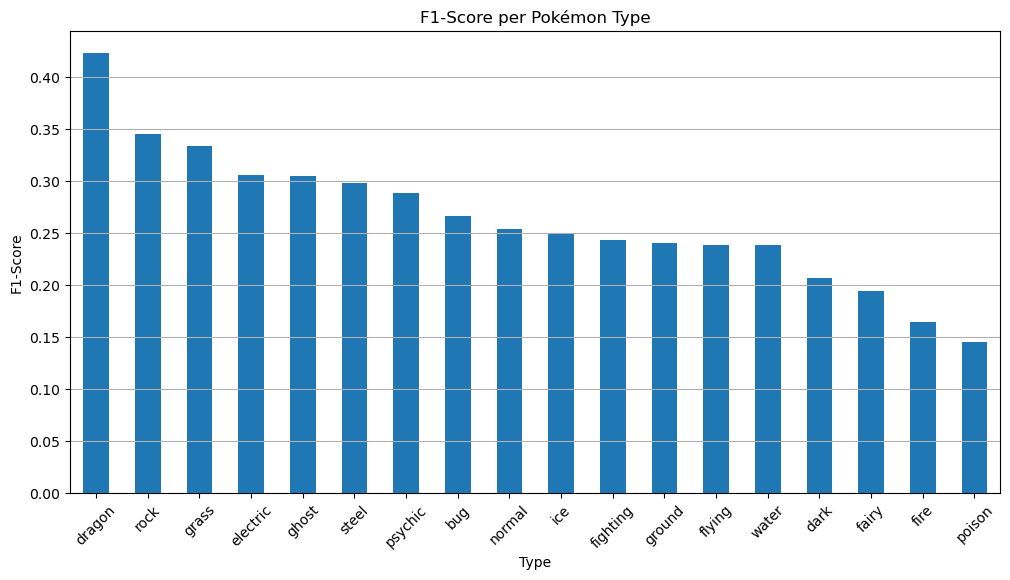

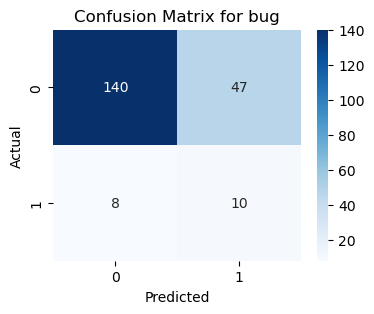

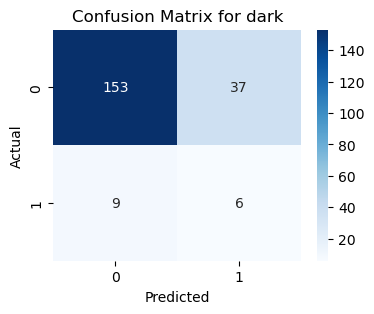

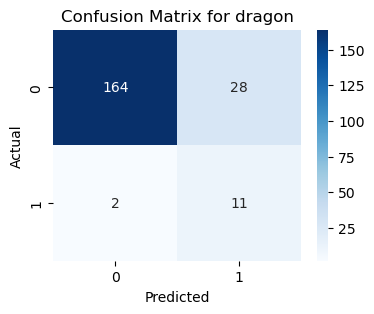

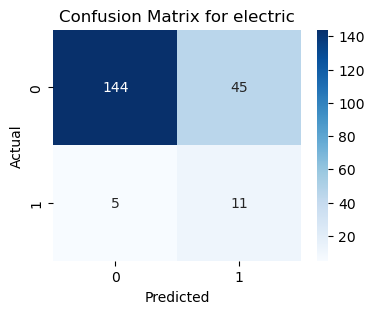

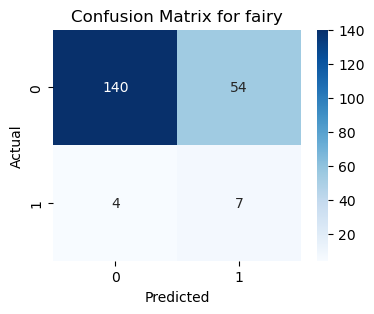

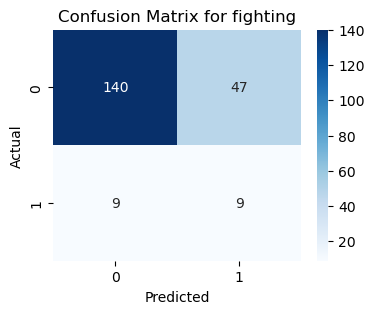

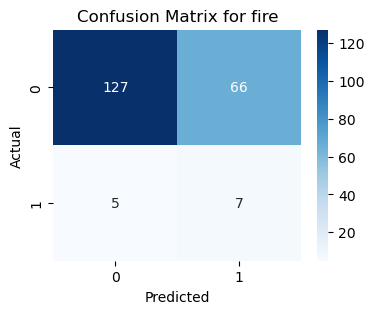

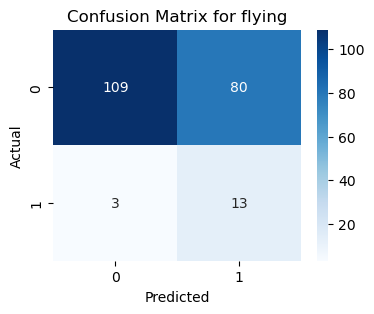

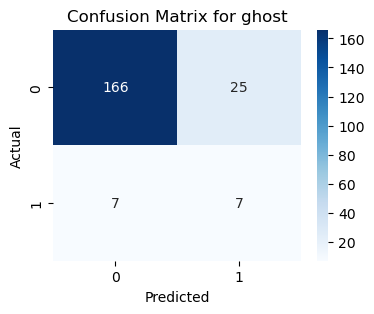

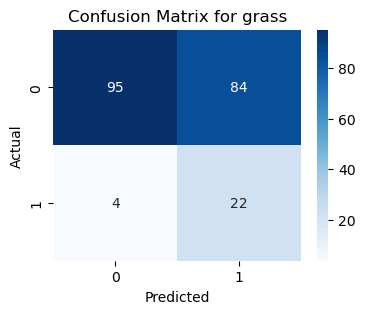

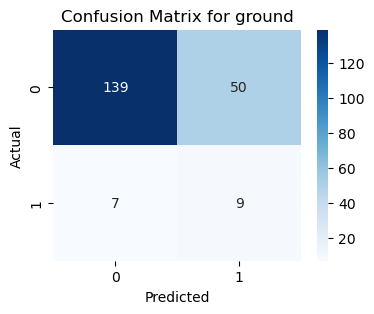

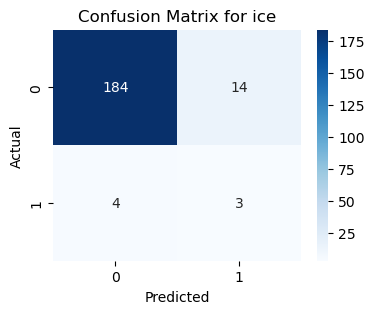

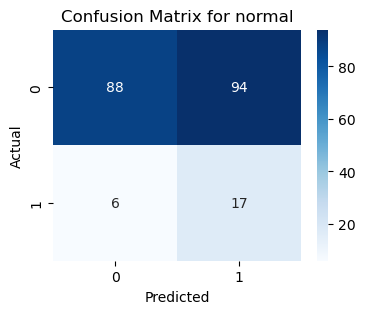

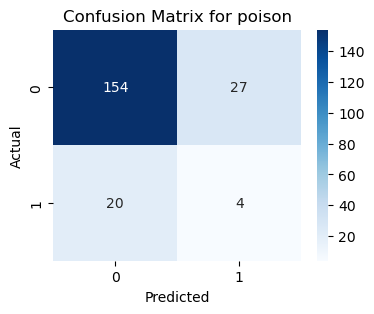

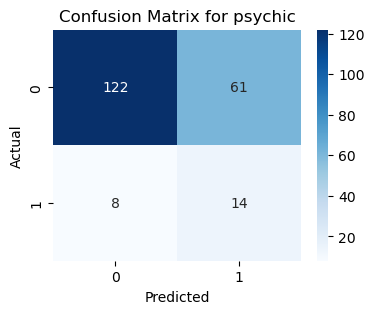

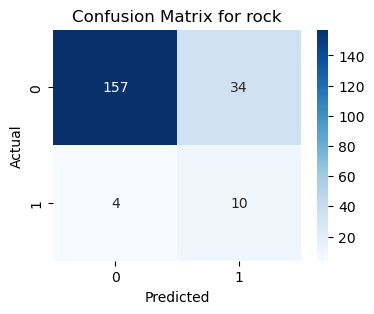

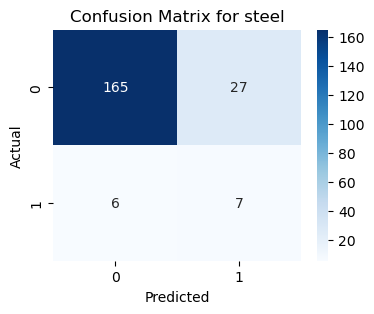

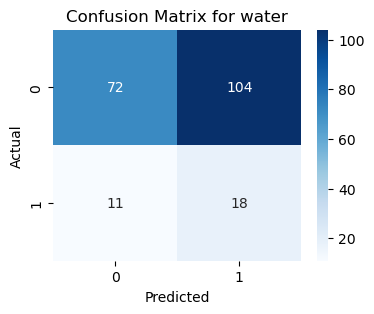

In [58]:
# Evaluation script for multi-label Pokemon type prediction

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import seaborn as sns


# Print detailed classification report
report = classification_report(y_test, y_pred, target_names=mlb.classes_, output_dict=True)

# Convert report to DataFrame for easier visualization
import pandas as pd
report_df = pd.DataFrame(report).transpose()

# Display F1 scores per type
f1_scores = report_df.loc[mlb.classes_, 'f1-score']

plt.figure(figsize=(12,6))
f1_scores.sort_values(ascending=False).plot(kind='bar')
plt.title('F1-Score per Pokémon Type')
plt.ylabel('F1-Score')
plt.xlabel('Type')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# Optionally: Display confusion matrices for a few types
conf_matrices = multilabel_confusion_matrix(y_test, y_pred)

# Example: Plot confusion matrix for the first few types
for idx, type_name in enumerate(mlb.classes_[:18]):
    cm = conf_matrices[idx]
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {type_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()



In [59]:
y_pred_probs = model.predict([X_test_text, X_test_stats])
print("Max prob:", np.max(y_pred_probs))
print("Mean prob:", np.mean(y_pred_probs))


7/7 [==============================] - 1s 72ms/step
Max prob: 0.9190019
Mean prob: 0.08482413


In [60]:
import numpy as np

pred_counts = y_pred.sum(axis=0)
true_counts = y_test.sum(axis=0)

for cls, pred, true in zip(mlb.classes_, pred_counts, true_counts):
    print(f"{cls:10s} | predicted: {pred:3d} | actual: {true:3d}")


bug        | predicted:  57 | actual:  18
dark       | predicted:  43 | actual:  15
dragon     | predicted:  39 | actual:  13
electric   | predicted:  56 | actual:  16
fairy      | predicted:  61 | actual:  11
fighting   | predicted:  56 | actual:  18
fire       | predicted:  73 | actual:  12
flying     | predicted:  93 | actual:  16
ghost      | predicted:  32 | actual:  14
grass      | predicted: 106 | actual:  26
ground     | predicted:  59 | actual:  16
ice        | predicted:  17 | actual:   7
normal     | predicted: 111 | actual:  23
poison     | predicted:  31 | actual:  24
psychic    | predicted:  75 | actual:  22
rock       | predicted:  44 | actual:  14
steel      | predicted:  34 | actual:  13
water      | predicted: 122 | actual:  29


In [61]:
import pandas as pd

df['type_list'] = df[['type1', 'type2']].values.tolist()
df['type_list'] = df['type_list'].apply(lambda x: [t for t in x if pd.notna(t)])

all_types = pd.Series([t for sublist in df['type_list'] for t in sublist])
print(all_types.value_counts())


water       154
normal      131
grass       127
flying      109
psychic     102
bug          92
poison       83
fire         81
ground       75
rock         74
fighting     73
dragon       70
dark         69
electric     69
steel        65
ghost        65
fairy        64
ice          48
Name: count, dtype: int64
